## Train data prep

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random 
import pickle
from tqdm.notebook import tqdm

DATA_DIR = "./data/train" # 48x48 px image
CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

training_data = []

def create_training_data():
    with tqdm(total=len(CATEGORIES)) as pbar_cat:
        for CATEGORY in CATEGORIES:
            path = os.path.join(DATA_DIR, CATEGORY)
            imgs_list = os.listdir(path)
            with tqdm(total=len(imgs_list)) as pbar_img:
                for img_name in os.listdir(path):
                    class_ = CATEGORIES.index(CATEGORY)
                    img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
                    training_data.append([img_array, class_])
                    pbar_img.update(1)
            pbar_cat.update(1)
            
create_training_data()


random.shuffle(training_data)

IMG_SIZE = 48

X=[]
y=[]

with tqdm(total=len(CATEGORIES)) as pbar_t_data:
    for features, label in training_data:
        X.append(features)
        y.append(label)
        pbar_t_data.update(1)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #1 for gray scale, 3 for color img0
y = np.array(y)

 # expoet cleaned data

pickle_out=open("X-{}.pickle".format(IMG_SIZE), "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out=open("y-{}.pickle".format(IMG_SIZE), "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## TEST data prep for model evaluation

In [ ]:
import random 
import pickle
import os
import cv2 
import numpy as np

TEST_DATA_DIR = "./data/test" # 48x48 px image
CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

testing_data = []

def create_testing_data():
    for CATEGORY in CATEGORIES:
        path = os.path.join(TEST_DATA_DIR, CATEGORY)
        for img_name in os.listdir(path):
            class_ = CATEGORIES.index(CATEGORY)
            img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
            testing_data.append([img_array, class_])
            
create_testing_data()

random.shuffle(testing_data)

IMG_SIZE = 48

X_test=[]
y_test=[]

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #1 for gray scale, 3 for color img0
y_test = np.array(y_test)


pickle_out=open("X-test-{}.pickle".format(IMG_SIZE), "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out=open("y-test-{}.pickle".format(IMG_SIZE), "wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()


# predictions

In [ ]:
import tensorflow as tf

MODEL_DIR = "./old_models/"

MODEL_NAME = "emo-analysis-Adam-decay-lr-10-epoch-3-conv-128-nodes-0-dense-1613888403.model"

for model in os.listdir(MODEL_DIR):
    print(model)
    model = tf.keras.models.load_model(MODEL_DIR + model)
    model_eval = model.evaluate(X_test, y_test)
    print(model_eval)

## External image predictions

### open cv video capture fps calculation

In [ ]:
import cv2
import tensorflow as tf
import os
import numpy as np
from tqdm.notebook import tqdm, trange

IMG_SIZE = 48

TEST_DIR_PATH = "./extdata"

MODEL_DIR = "./old_models/"

#best so far 
## emo-analysis-Adam-decay-lr-3-conv-128-nodes-1-dense-1613837977.model

MODEL_NAME = "emo-analysis-Adam-decay-lr-3-conv-128-nodes-1-dense-1613837977.model"

CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def prepare(path):
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1) # 1:gray scale 3:color image

model = tf.keras.models.load_model(MODEL_DIR + MODEL_NAME)



for img_path in os.listdir(TEST_DIR_PATH):
    preprd_img = prepare(os.path.join(TEST_DIR_PATH, img_path))
    pred = model.predict([preprd_img])
#     print(np.argmax(pred))
    print("{} - {}".format(os.path.join(TEST_DIR_PATH, img_path), CATEGORIES[np.argmax(pred)]))

In [ ]:
video = cv2.VideoCapture("test.mp4");

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print "Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps)
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print "Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps)

video.release(); 

## Live Emotion Detection usng OpenCV

### open cv video capture - 7 fps w/ and 10 fps w/o emotion analysis.

In [10]:
import numpy as np
import cv2
import time as t
import tensorflow as tf

IMG_SIZE = 48

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# web cam 
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("video.mov")

STRECH = 10

CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

COLORS = {
     'angry':  (0, 0, 255), 
     'disgust': (0, 255, 255), 
     'fear':    (255,145,0), 
     'happy':   (0, 255, 0), 
     'neutral': (0, 53, 255), 
     'sad':     (255, 26, 0), 
     'surprise':(255, 0, 255)
}

MODEL_DIR = "./best/"
MODEL_NAME = "emo-analysis-Adam-decay-lr-3-conv-128-nodes-1-dense-1613837977.model" # - best so far

model = tf.keras.models.load_model(MODEL_DIR + MODEL_NAME)

emo_sum = []

new_fp = 0
prev_fp = 0

window_name = 'Image'
font = cv2.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
color = (255, 0, 0) 
thickness = 2
emotions = []
pred = np.zeros(7)
frames__ = 0
while 1:
    try:
        ret, img = cap.read()
        frames__ += 1
        pred = np.zeros(7)
        if not ret:
            break
        new_fp = t.time()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        time_str = str(int(t.time()))
        for (x,y,w,h) in faces:
            x-=STRECH
            y-=STRECH
            w+=STRECH*2
            h+=STRECH*2
            roi_gray = gray[y:y+h, x:x+w]
    #         roi_color = img[y:y+h, x:x+w]
            img_array = cv2.resize(roi_gray, (IMG_SIZE, IMG_SIZE))
            img_array = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
            org = (x-10, y-10)
            pred = model.predict([img_array])
            emotion = CATEGORIES[np.argmax(pred)]
            emotions.append(emotion)
            cv2.rectangle(img,(x,y),(x+w,y+h),COLORS[emotion],2)
            img=cv2.putText(img,emotion, org, font,
                           fontScale, COLORS[emotion], thickness, cv2.LINE_AA)

        fps = 1/(new_fp - prev_fp)
        fps = str(int(fps))
        prev_fp = new_fp
        emo_sum.append(pred)
        cv2.putText(img, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
        cv2.imshow('img',img)
        cv2.imwrite(r'./faces/'+'face-'+','.join(emotions)+'.png', img)
        emotions.clear()
    except Exception as e:
        pass
    k = cv2.waitKey(1)
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [12]:
len(emo_sum)

509

510

In [ ]:
import matplotlib.pyplot as plt
emotion_data = []
for d in emo_sum:
    emotion_data.append(d[0])
angry, disgust, fear, happy, neutral, sad, surprise = plt.plot(emotion_data)
plt.show()

In [ ]:
emotion_data

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4],[2,3,4,5])
plt.axis([0, 6, 0, 20])
plt.show()

In [5]:
import pickle
pickle_out=open("emotion-data.pickle", "wb")
pickle.dump(emo_sum, pickle_out)
pickle_out.close()

# Emotion Visuavalization

### ploting emotion graphs using predictions

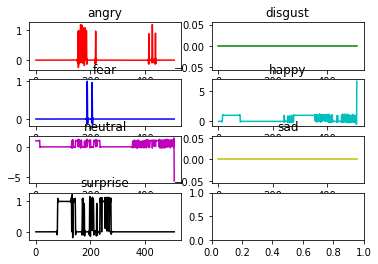

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

emo_sum=pickle.load(open("emotion-data.pickle", "rb"))

SUM_LEN = len(emo_sum)

CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

COLORS = {
     'angry':  (0, 0, 255), 
     'disgust': (0, 255, 255), 
     'fear':    (255,145,0), 
     'happy':   (0, 255, 0), 
     'neutral': (0, 53, 255), 
     'sad':     (255, 26, 0), 
     'surprise':(255, 0, 255)
}

angry = []
disgust = []
fear = []
happy = []
neutral = []
sad = []
surprise = []

T = [i for i in range(SUM_LEN)]
xnew = np.linspace(0, SUM_LEN, 1000)

for d in emo_sum:
    angry.append(d[0][CATEGORIES.index('angry')])
    disgust.append(d[0][CATEGORIES.index('disgust')])
    fear.append(d[0][CATEGORIES.index('fear')])
    happy.append(d[0][CATEGORIES.index('happy')])
    neutral.append(d[0][CATEGORIES.index('neutral')])
    sad.append(d[0][CATEGORIES.index('sad')])
    surprise.append(d[0][CATEGORIES.index('surprise')])

spl = make_interp_spline(T, angry, k=3) # type: BSpline
angry_smooth = spl(xnew)


spl = make_interp_spline(T, disgust, k=3) # type: BSpline
disgust_smooth = spl(xnew)


spl = make_interp_spline(T, fear, k=3) # type: BSpline
fear_smooth = spl(xnew)


spl = make_interp_spline(T, happy, k=3) # type: BSpline
happy_smooth = spl(xnew)


spl = make_interp_spline(T, neutral, k=3) # type: BSpline
neutral_smooth = spl(xnew)


spl = make_interp_spline(T, sad, k=3) # type: BSpline
sad_smooth = spl(xnew)


spl = make_interp_spline(T, surprise, k=3) # type: BSpline
surprise_smooth = spl(xnew)

fig,((angry, disgust), (fear, happy), (neutral, sad), (surprise, n)) = plt.subplots(4,2)

# angry, disgust, fear, happy, neutral, sad, surprise = plt.plot(emotion_data)
angry.plot(xnew, angry_smooth, 'r')
angry.set_title('angry')
disgust.plot(xnew, disgust_smooth, 'g')
disgust.set_title('disgust')
fear.plot(xnew, fear_smooth, 'b')
fear.set_title('fear')
happy.plot(xnew, happy_smooth, 'c')
happy.set_title('happy')
neutral.plot(xnew, neutral_smooth, 'm')
neutral.set_title('neutral')
sad.plot(xnew, sad_smooth, 'y')
sad.set_title('sad')
surprise.plot(xnew, surprise_smooth, 'k')
surprise.set_title('surprise')
plt.show()

### summerizing emotions

### Video Emotion Visualization based on time

#### Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0

<ipython-input-37-66ae7918a64d>:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  cline.set_yticks(y, CATEGORIES)


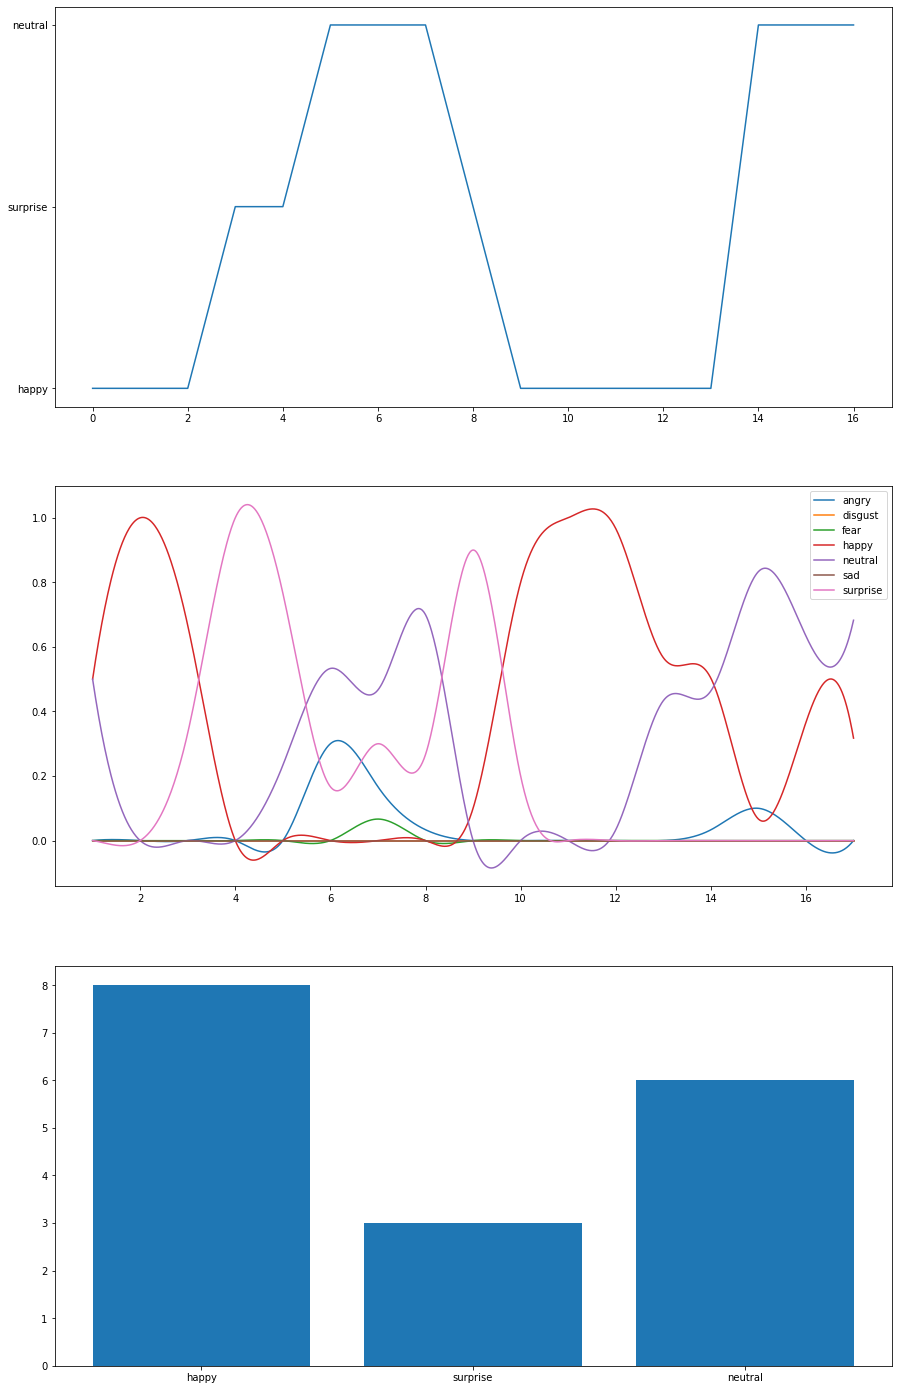

In [37]:
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

emo_sum=pickle.load(open("emotion-data.pickle", "rb"))

CATEGORIES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def draw_single_line_chart(cline, emo_data):
    emotions = []
    cat_len = len(CATEGORIES)
    for d in emo_data:
        emotions.append(CATEGORIES[np.argmax(d)])
    y = [i for i in range(cat_len)]
    video_len = [i for i in range(len(emo_data))]
    cline.set_yticks(y, CATEGORIES)
    cline.plot(video_len, emotions)

def draw_bar_chart(bar, emo_data):
    emo_cnt = {}

    for dp in emo_data:
        emo = CATEGORIES[np.argmax(dp)]
        if emo not in emo_cnt:
            emo_cnt[emo] = 1
        else:
            emo_cnt[emo] += 1
    keys = emo_cnt.keys()
    values = emo_cnt.values()
    bar.bar(keys, values)
    
def draw_line_chart(line, emo_data):
    emo_data = [d[0] for d in emo_data]
    video_length = len(emo_data)
    T = np.arange(1,video_length+1)
    xnew = np.linspace(T.min(), T.max(), 1000)
    spl = make_interp_spline(T, emo_data, k=3)
    emo_data_smooth = spl(xnew)
    
    line.plot(xnew, emo_data_smooth)
    line.legend(loc="upper right", labels=CATEGORIES)
    
def get_avg_emo_data(emo_data):
    FPS = 30

    len_ = len(emo_data)

    video_length_in_seconds = math.ceil(len_/FPS)

    avg_emo_data=[]

    for sec in range(video_length_in_seconds):
        start = sec*FPS
        end = start+FPS
        avg_emo_data.append(np.mean(emo_data[start:end], axis=0))

    return avg_emo_data
    

def draw_emotion_charts(emo_data):
    avg_emo_data = get_avg_emo_data(emo_data)
    fig, ((cline, line, bar)) = plt.subplots(3,1, figsize=(15,25))
    draw_line_chart(line, avg_emo_data)
    draw_bar_chart(bar, avg_emo_data)
    draw_single_line_chart(cline, avg_emo_data)
    plt.show()


draw_emotion_charts(emo_sum)


In [5]:
import numpy as np
aaa = [1,2,3,4,5]
np.argmax(aaa)

4

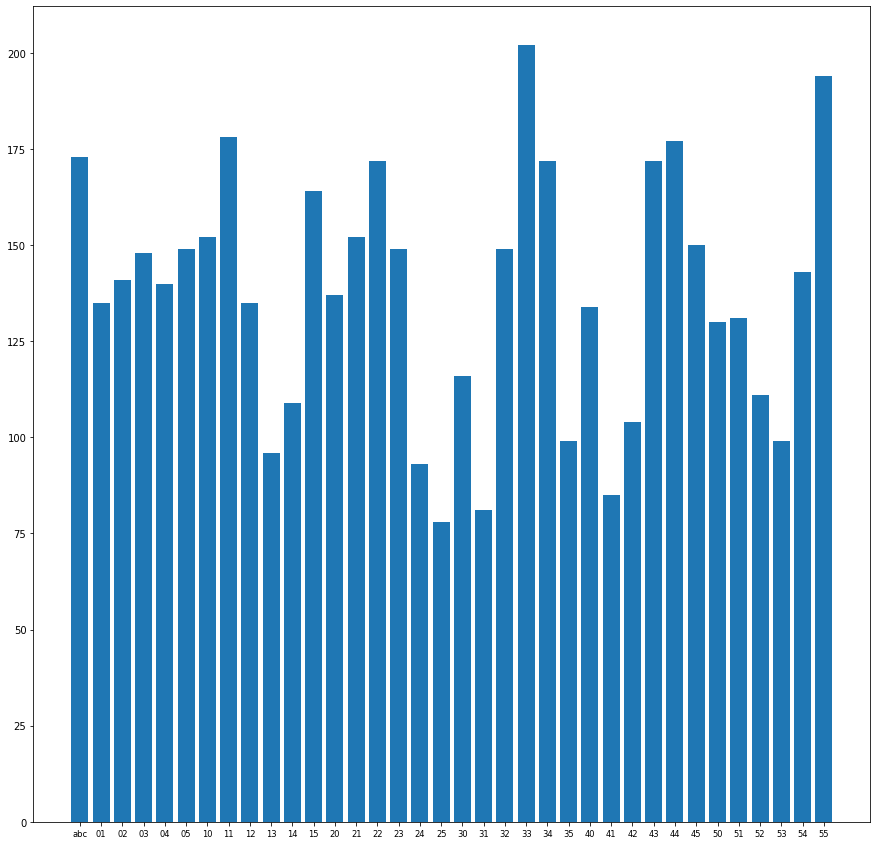

In [22]:
import matplotlib.pyplot as plt

t11 = ['abc', '01', '02', '03', '04', '05', '10', '11', '12', '13', '14', '15',
       '20', '21', '22', '23', '24', '25', '30', '31', '32', '33', '34', '35',
       '40', '41', '42', '43', '44', '45', '50', '51', '52', '53', '54', '55']

t12 = [173, 135, 141, 148, 140, 149, 152, 178, 135, 96, 109, 164, 137, 152,
       172, 149, 93, 78, 116, 81, 149, 202, 172, 99, 134, 85, 104, 172, 177,
       150, 130, 131, 111, 99, 143, 194]

plt.figure(figsize=(15,15))
plt.bar(range(len(t12)), t12, align='center')
plt.xticks(range(len(t11)), t11, size='small')
plt.show()